In [1]:
# Stdlib packages
import copy
import datetime
import json
import os
import re
from pathlib import Path

# Common Py packages
import numpy as np
import pandas
from matplotlib import pyplot as plt
from prettytable import PrettyTable

# HEP packages
import gpustat
import h5py
import hist
import mplhep as hep
from cycler import cycler

# ML packages
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader

# Module packages
from AMSGrad import AMSGrad
from data_processing import process_data
from evaluate import evaluate
from InclusiveNetwork import InclusiveNetwork
from ParticleHLF import ParticleHLF
from space_optimization import optimize_hyperparams
from train import train

gpustat.print_gpustat()
print(torch.cuda.is_available())
SEED = 21
OPTIMIZE_SPACE = False

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})
cmap_petroff10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams.update({"axes.prop_cycle": cycler("color", cmap_petroff10)})

cmslpcgpu1.fnal.gov      Wed Aug 14 20:58:43 2024  555.42.02
[0] Tesla P100-PCIE-12GB | 43°C,   0 % |     0 / 12288 MB |
True


In [2]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

SIGNAL_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/GluGluToHH/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/GluGluToHH/nominal/*"]
SIGNAL_FILEPATHS = [
    lpc_fileprefix+"/Run3_2022preEE_merged/GluGluToHH/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/GluGluToHH/nominal/*",
    lpc_fileprefix+"/Run3_2022preEE_merged/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*",
]
BKG_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/ttHToGG/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/ttHToGG/nominal/*"]


CURRENT_DIRPATH = str(Path().absolute())
# OUTPUT_DIRPATH = CURRENT_DIRPATH + "/model_outputs/v1/extra_vars/"
# CURRENT_TIME = '2024-08-10_13-16-12'
OUTPUT_DIRPATH = CURRENT_DIRPATH + "/model_outputs/v1/base_vars/"
CURRENT_TIME = '2024-08-10_10-29-50'
if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

In [3]:
sig_train_df, sig_test_df, bkg_train_df, bkg_test_df, data_list, data_hlf, label, data_list_test, data_hlf_test, label_test, high_level_fields, input_hlf_vars, hlf_vars_columns = process_data(
    SIGNAL_FILEPATHS, BKG_FILEPATHS, OUTPUT_DIRPATH, seed=SEED
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

Data list: (543639, 4, 6)
Data HLF: (543639, 9)
Data list test: (545732, 4, 6)
Data HLF test: (545732, 9)


### Run the optimization

In [32]:
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

if OPTIMIZE_SPACE:
    config_file = OUTPUT_DIRPATH + CURRENT_TIME + 'BestConfigReallyTopclass.json'
    best_conf = optimize_hyperparams(
        skf, data_list, data_hlf, label, 
        config_file, len(input_hlf_vars), epochs=10
    )
    print(best_conf)
else:
    # with open(OUTPUT_DIRPATH + CURRENT_TIME + config_file + '.json') as f:
    with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
        best_conf = json.load(f)
        print(best_conf)

fom = []
criterion= nn.NLLLoss()
train_losses_arr, val_losses_arr = [], []
for fold_idx, (train_index, test_index) in enumerate(skf.split(data_hlf, label)):
    model_file = OUTPUT_DIRPATH + CURRENT_TIME +'_ReallyTopclassStyle_'+ f'_{fold_idx}.torch'
    state_file = OUTPUT_DIRPATH + CURRENT_TIME +'_BestPerfReallyTopclass_'+ f'_{fold_idx}.torch'
    
    model = InclusiveNetwork(
        best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
        best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g'], dnn_input=len(input_hlf_vars)
    ).cuda()
    optimizer = AMSGrad(model.parameters(), lr=best_conf['learning_rate'], weight_decay=best_conf['L2_reg'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=3)
    
    train_loader = DataLoader(
        ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), 
        batch_size=best_conf['batch_size'], 
        shuffle=True
    )
    val_loader = DataLoader(
        ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), 
        batch_size=best_conf['batch_size'], 
        shuffle=True
    )
    data_loader = {"training": train_loader, "validation": val_loader} 

    best_acc, train_losses, val_losses = train(
        150, model, criterion, optimizer, scheduler, 
        state_file, model_file, data_loader=data_loader
    )
    train_losses_arr.append(train_losses)
    val_losses_arr.append(val_losses)

    fom.append(best_acc)

Y = np.mean(np.asarray([acc.cpu() for acc in fom]))
print("Average best_acc across k-fold: {}".format(Y))
model = InclusiveNetwork(
    best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
    best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g']
).cuda()

{'hidden_layers': 2, 'initial_nodes': 500, 'dropout': 0.01, 'gru_layers': 2, 'gru_size': 442, 'dropout_g': 0.01, 'learning_rate': 0.003297552560160522, 'batch_size': 4000, 'L2_reg': 4.783663281646104e-05}
Loaded best configuration from BestConfigReallyTopclass
Fold 0
Epoch 0/149
training Loss: 0.0001 Acc: 85.1457
validation Loss: 0.0001 Acc: 87.2940
Saving..
Epoch 1/149
training Loss: 0.0001 Acc: 86.4761
validation Loss: 0.0001 Acc: 87.3565
Saving..
Epoch 2/149
training Loss: 0.0001 Acc: 88.0325
validation Loss: 0.0001 Acc: 88.4767
Saving..
Epoch 3/149
training Loss: 0.0001 Acc: 88.7154
validation Loss: 0.0001 Acc: 88.5604
Saving..
Epoch 4/149
training Loss: 0.0001 Acc: 88.8543
validation Loss: 0.0001 Acc: 89.0295
Saving..
Epoch 5/149
training Loss: 0.0001 Acc: 88.9315
validation Loss: 0.0001 Acc: 88.8980
Epoch 6/149
training Loss: 0.0001 Acc: 89.1238
validation Loss: 0.0001 Acc: 89.0111
Epoch 7/149
training Loss: 0.0001 Acc: 89.1523
validation Loss: 0.0001 Acc: 89.2337
Saving..
Epoch 

### Performance on test set

Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.2800  |       0.9706      |    0.2997 +/- 0.0007     |
|   0.4124  |       0.9500      |    0.2159 +/- 0.0009     |
|   0.5611  |       0.9198      |    0.1476 +/- 0.0007     |
|   0.8922  |       0.7538      |    0.0335 +/- 0.0002     |
|   0.9698  |       0.5777      |    0.0086 +/- 0.0001     |
|   0.9924  |       0.3839      |    0.0017 +/- 0.0001     |
+-----------+-------------------+--------------------------+
Saved ROC.


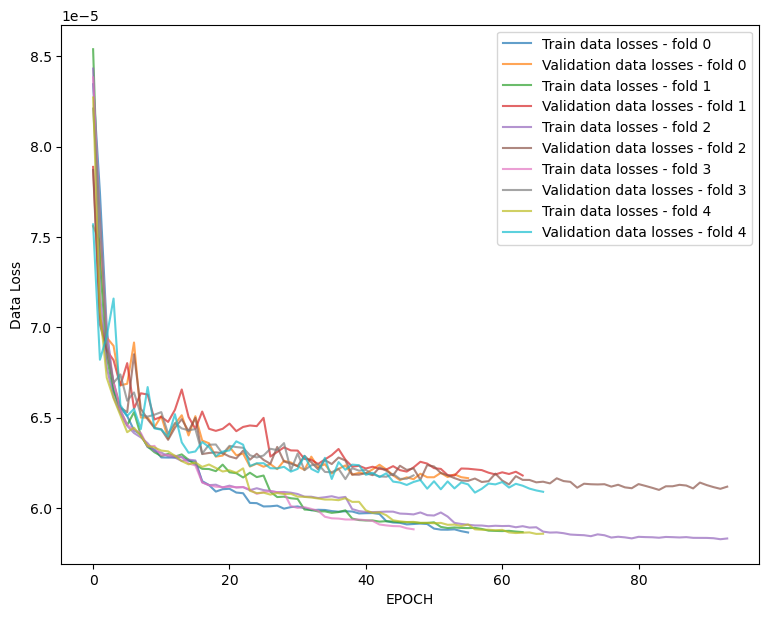

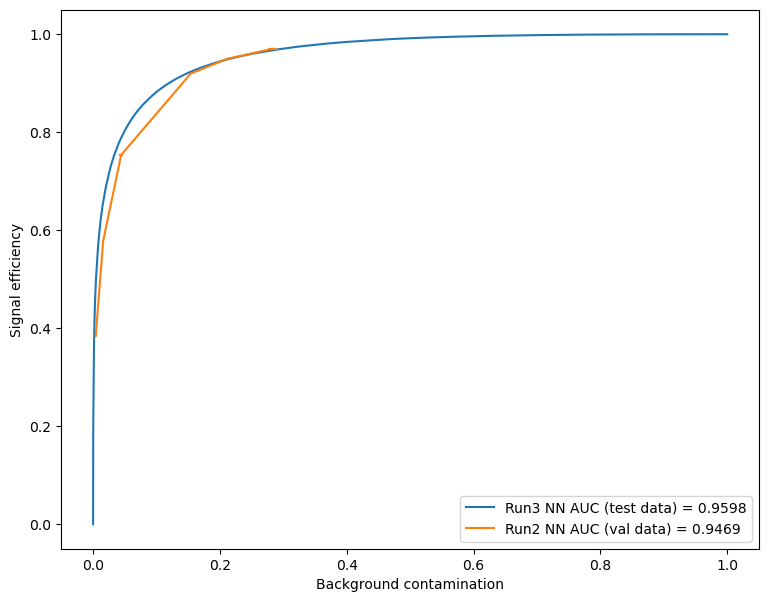

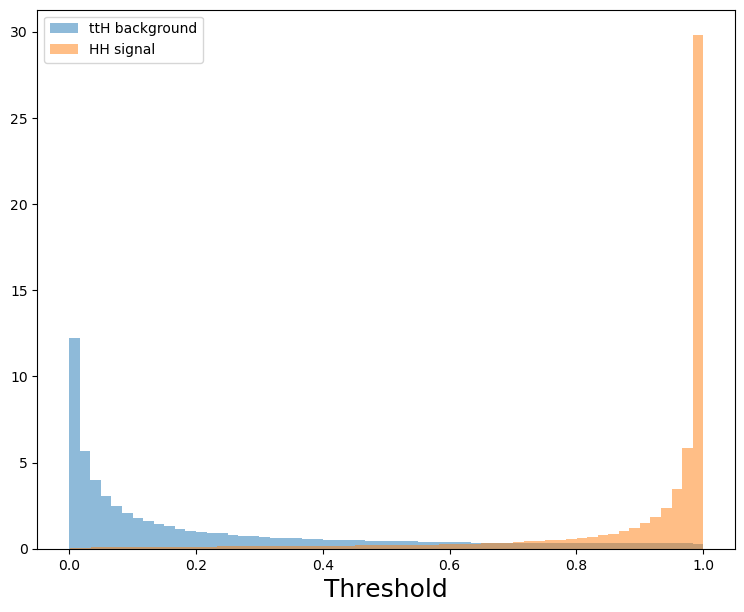

In [34]:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + config_file + '.json') as f:
with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
    best_conf = json.load(f)
try:
    IN_perf = evaluate(
        data_list_test, data_hlf_test, label_test, 
        OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, 
        train_losses_arr=train_losses_arr, val_losses_arr=val_losses_arr, save=True
    )
except:
    IN_perf = evaluate(
        data_list_test, data_hlf_test, label_test, 
        OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, save=True
    )

In [4]:
def plot_train_val_losses(IN_info, plot_prefix, plot_postfix='', method='arr'):
    plt.figure(figsize=(9,7))
    if method == 'std':
        plt.plot(range(len(IN_info['train_losses_arr'])), IN_info['train_losses_arr'], label=f"Train data losses", alpha=0.7)
        plt.plot(range(len(IN_info['train_losses_arr'])), IN_info['val_losses_arr'], label=f"Validation data losses", alpha=0.7)
    elif method == 'arr':
        for fold_idx in range(skf.get_n_splits()):
            plt.plot(range(len(IN_info['train_losses_arr'][fold_idx])), IN_info['train_losses_arr'][fold_idx], label=f"Train data losses - fold {fold_idx}", alpha=0.7)
            plt.plot(range(len(IN_info['train_losses_arr'][fold_idx])), IN_info['val_losses_arr'][fold_idx], label=f"Validation data losses - fold {fold_idx}", alpha=0.7)
    else:
        raise Exception(f"Must used methods 'std' or 'arr'. You used {method}.")
    plt.legend(loc='best')
    plt.xlabel('EPOCH')
    plt.ylabel('Data Loss')
    plt.savefig(f'{plot_prefix}_train_val_losses{plot_postfix}.pdf')
    plt.savefig(f'{plot_prefix}_train_val_losses{plot_postfix}.png')

def plot_roc(IN_info, plot_prefix, plot_postfix='', method='std', labels=None):
    run2_sigEff = [.9704, .9498, .9196, .7536, .5777, .3837]
    run2_bkgCont = [.2831, .2114, .1539, .0442, .0158, .0041]
    run2_bkgCont_err = [.0077, .0036, .0011, .0032, .0006, .0001]
    plt.figure(figsize=(9,7))
    if method == 'std':
        plt.plot(IN_info['mean_fprs'], IN_info['base_tpr'],label="Run3 NN AUC = %.4f" % (IN_info['mean_area']))
    elif method == 'arr':
        for fold_idx in range(skf.get_n_splits()):
            plt.plot(IN_info['fprs'][fold_idx], IN_info['base_tpr'][fold_idx], label="Run3 NN - fold %d" % (fold_idx))
    elif method == 'IN_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        for i in range(len(IN_info)):
            plt.plot(
                IN_info[i]['mean_fprs'], IN_info[i]['base_tpr'], 
                label=(labels[i]+', ' if labels is not None else '') + "AUC = %.4f" % (IN_info[i]['mean_area']), 
                linestyle=linestyles[i]
            )
    else:
        raise Exception(f"Must used methods 'std' or 'arr'. You used {method}.")
    plt.errorbar(run2_bkgCont, run2_sigEff, xerr=run2_bkgCont_err, label="Run2 NN AUC (val data) = {}".format(0.9469))
    plt.legend(loc='best')
    plt.xlabel('Background contamination')
    plt.ylabel('Signal efficiency')
    plt.savefig(f'{plot_prefix}_roc_curve{plot_postfix}.pdf')
    plt.savefig(f'{plot_prefix}_roc_curve{plot_postfix}.png')

def plot_output_score(IN_info, plot_prefix, plot_postfix='', method='arr', labels=None):
    plt.figure(figsize=(9,7))
    if method == 'std':
        plt.hist(np.exp(IN_info[0]['all_preds'])[IN_info[0]['all_labels']==0,1], bins=60, label='ttH background', histtype='step', alpha=0.5, density=True)
    elif method == 'arr':
        for fold_idx in range(skf.get_n_splits()):
            plt.hist(np.exp(IN_info['all_preds'][fold_idx])[IN_info['all_labels'][fold_idx]==0,1], bins=60, label='ttH background', 
                histtype='step', alpha=0.5, density=True
            )
            plt.hist(
                np.exp(IN_info['all_preds'][fold_idx])[IN_info['all_labels'][fold_idx]==1,1], bins=60, label='HH signal', 
                histtype='step', alpha=0.5, density=True
            )
    elif method == 'IN_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        for i in range(len(IN_info)):
            plt.hist(
                np.exp(IN_info[i]['all_preds'][0])[IN_info[i]['all_labels'][0]==0,1], bins=60, 
                label='ttH background'+(' - '+labels[i] if labels is not None else ''), 
                histtype='step', linestyle=linestyles[i], alpha=0.5, density=True
            )
            plt.hist(
                np.exp(IN_info[i]['all_preds'][0])[IN_info[i]['all_labels'][0]==1,1], bins=60, 
                label='HH signal'+(' - '+labels[i] if labels is not None else ''), 
                histtype='step', linestyle=linestyles[i], alpha=0.5, density=True
            )
    else:
        raise Exception(f"Must used methods 'std' or 'arr'. You used {method}.")
    plt.legend(loc='best')
    plt.xlabel("Threshold", fontsize=18)
    plt.savefig(f'{plot_prefix}_model_score_dist{plot_postfix}.pdf')
    plt.savefig(f'{plot_prefix}_model_score_dist{plot_postfix}.png')

In [ ]:
# with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}IN_perf_{fold_idx}.json', 'r') as f:
#     IN_perf = json.load(f)

TPR_thresholds = [0.9704, 0.9498, 0.9196, 0.7536, 0.5777, 0.3837]
print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(IN_perf['base_tpr']>TPR_threshold)
    NNtable.add_row(
        [
            IN_perf['mean_thresholds'][thres_idx], IN_perf['base_tpr'][thres_idx], 
            "{:.4f} +/- {:.4f}".format(IN_perf['mean_fprs'][thres_idx], IN_perf['std_fprs'][thres_idx])
        ]
    )
print(NNtable)

plot_destdir = OUTPUT_DIRPATH + 'plots'
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)

plot_train_val_losses(IN_perf, plot_destdir+'/'+CURRENT_TIME)
plot_roc(IN_perf, plot_destdir+'/'+CURRENT_TIME)
plot_output_score(IN_perf, plot_destdir+'/'+CURRENT_TIME, method='arr')

### Gaussian smearing on test set

In [5]:
def data_list_index_map(variable_name):
    # Order of these ifs is important b/c 'lepton' contains 'pt', so if you don't check 'pt' last there will be a bug.
    if re.search('phi', variable_name) is not None:
        index3 = 2
    elif re.search('eta', variable_name) is not None:
        index3 = 1
    else:
        index3 = 0

    # Order of these ifs is important b/c diphoton is only called 'pt' or 'eta', so it has to be checked last.
    if re.search('lepton', variable_name) is not None:
        if re.search('1', variable_name) is not None:
            index2 = 0
        else:
            index2 = 1
    elif re.search('MET', variable_name) is not None:
        index2 = 3
    else:
        index2 = 2
    
    return index2, index3

def smear_particle_list(variable_name, particle_list_to_smear, method='multiply', seed=21):
    index2, index3 = data_list_index_map(variable_name)

    # Performs the smearing and returns the result
    rng = np.random.default_rng(seed=seed)
    if method == 'multiply':
        for i in range(len(particle_list_to_smear[:, index2, index3])):
            particle_list_to_smear[i, index2, index3] *= rng.normal()
    elif method == 'add':
        for i in range(len(particle_list_to_smear[:, index2, index3])):
            particle_list_to_smear[i, index2, index3] += rng.normal()
    else:
        raise Exception(f"Only 'multiply' and 'add' are allowed as methods. You passed {method}.")

    return particle_list_to_smear


def smear_particle_hlf(variable_name, particle_hlf_to_smear, method='multiply', seed=21):
    index2 = hlf_vars_columns[variable_name]
    rng = np.random.default_rng(seed=seed)
    if method == 'multiply':
        for i in range(len(particle_hlf_to_smear)):
            particle_hlf_to_smear[i, index2] *= rng.normal()
    elif method == 'add':
        for i in range(len(particle_hlf_to_smear)):
            particle_hlf_to_smear[i, index2] += rng.normal()
    else:
        raise Exception(f"Only 'multiply' and 'add' are allowed as methods. You passed {method}.")
    
    return particle_hlf_to_smear

n_jets
Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1551  |       0.9706      |    0.4740 +/- 0.0056     |
|   0.2258  |       0.9500      |    0.3825 +/- 0.0065     |
|   0.3164  |       0.9198      |    0.2953 +/- 0.0074     |
|   0.6702  |       0.7538      |    0.0986 +/- 0.0052     |
|   0.8744  |       0.5777      |    0.0333 +/- 0.0024     |
|   0.9688  |       0.3839      |    0.0084 +/- 0.0010     |
+-----------+-------------------+--------------------------+
chi_t0
Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.0000  |       0.9706      |    0.9997 +/- 0.0000     |
|   0.0000  |       0.9500      |    0.9992 +/- 0.0000     |
|   0.0000  |    

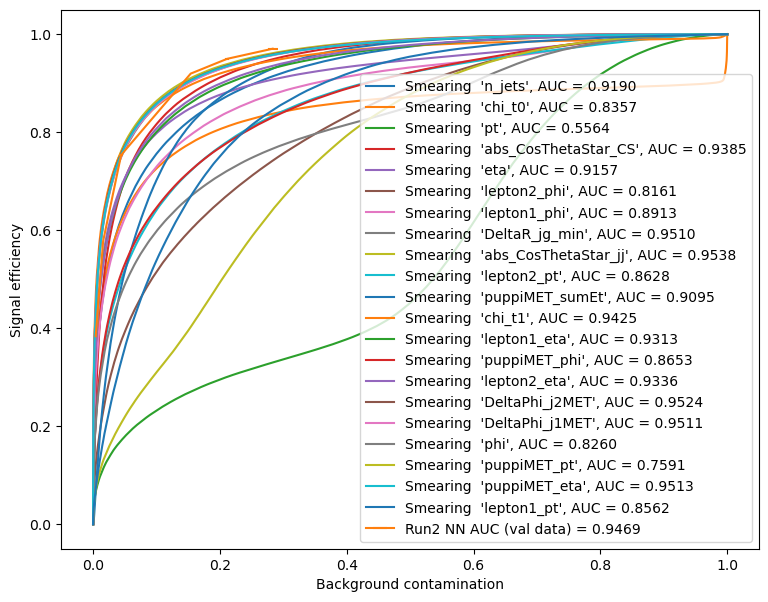

In [11]:
IN_perf_arr = []
# with open(OUTPUT_DIRPATH + CURRENT_TIME + config_file + '.json') as f:
with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
    best_conf = json.load(f)
for variable_name in high_level_fields:
    if variable_name == 'event':
        continue

    if variable_name in (high_level_fields - set(input_hlf_vars)):
        gauss_data_list = smear_particle_list(variable_name, copy.deepcopy(data_list_test))
        gauss_data_hlf = data_hlf_test
    else:
        gauss_data_list = data_list_test
        gauss_data_hlf = smear_particle_hlf(variable_name, copy.deepcopy(data_hlf_test))

    IN_perf_arr.append(
        evaluate(
            gauss_data_list, gauss_data_hlf, label_test, OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf
        )
    )

with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_gauss_smear.json', 'w') as f:
    json.dump({'IN_perf_arr': IN_perf_arr}, f)


(0.1, 1.1)

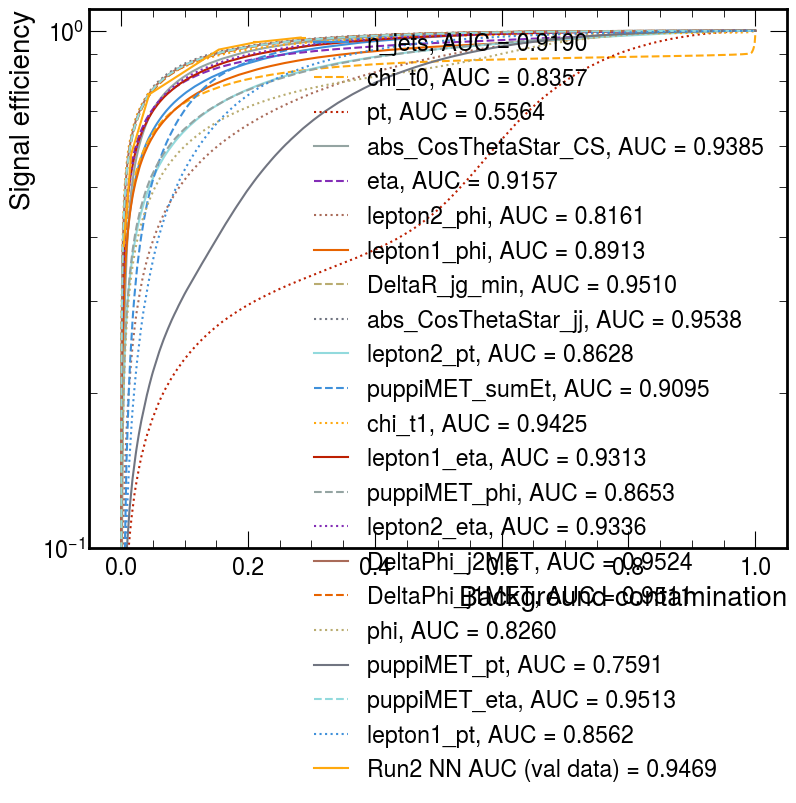

In [6]:
plot_destdir = OUTPUT_DIRPATH + 'plots'
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)
with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_gauss_smear.json', 'r') as f:
    IN_perf_arr = json.load(f)
IN_perf_arr = IN_perf_arr['IN_perf_arr']

plot_roc(
    IN_perf_arr, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_gauss_smear', 
    method='IN_arr', labels=[dict_['smeared_var'] for dict_ in IN_perf_arr]
)
plt.yscale('log')
plt.ylim(0.1, 1.1)

### Plotting

##### Input Vars (pre-standardization, post-, and combined)

In [6]:
MC_NAMES_PRETTY = {
    "GGJets": r"$\gamma\gamma+3j$",
    "GJetPt20To40": r"$\gamma+j$, 20<$p_T$<40GeV",
    "GJetPt40": r"$\gamma+j$, 40GeV<$p_T$",
    "GluGluHToGG": r"ggF $H\rightarrow \gamma\gamma$",
    "VBFHToGG": r"VBF $H\rightarrow \gamma\gamma$",
    "VHToGG": r"V$H\rightarrow\gamma\gamma$",
    "ttHToGG": r"$t\bar{t}H\rightarrow\gamma\gamma$",
    "GluGluToHH": r"ggF $HH\rightarrow bb\gamma\gamma$",
    # "VBFHHto2B2G_CV_1_C2V_1_C3_1": r"VBF $HH\rightarrow bb\gamma\gamma$",
    # Need to fill in pretty print for BSM samples #
}
LUMINOSITIES = {
    '2022preEE': 7.9804, 
    '2022postEE': 26.6717,
    # Need to fill in lumis for other eras #
}
LUMINOSITIES['total_lumi'] = sum(LUMINOSITIES.values())

# Dictionary of variables
VARIABLES = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(30, 0, 5, name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'jet1_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'jet2_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Integer(0, 10, name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, 0., 150, name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(30, 0., 500, name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'lepton1_pt': hist.axis.Regular(40, 0., 200, name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, 0., 200, name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, 20., 2000, name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(20, -5., 5., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
}
# Dictionary of variables to do MC/Data comparison
VARIABLES_STD = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(40, -4., 4., name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'jet1_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'jet2_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Regular(40, -4., 4., name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, -4., 4., name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(40, -4., 4., name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'lepton1_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, -4., 4., name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
}

def make_input_plot(output_dir, var_name, hist_list, fold_idx=None):
    fig, ax = plt.subplots()
    if fold_idx is not None:
        hep.histplot(
            hist_list, ax=ax, linewidth=3, histtype="step", yerr=True, density=True,
            color=["red", "red", "red", "green", "green", "green"], linestyle=["solid", "dashed", "dotted", "solid", "dashed", "dotted"], 
            label=[
                MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
                MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test"
            ],

        )
    else:
        hep.histplot(
            hist_list, ax=ax, linewidth=3, histtype="step", yerr=True, density=True,
            color=["red", "red", "green", "green"], linestyle=["solid", "dotted", "solid", "dotted"], 
            label=[
                MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
                MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
            ]
        )
    # Plotting niceties #
    hep.cms.lumitext(f"{LUMINOSITIES['total_lumi']:.2f}" + r"fb$^{-1}$ (13.6 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    # Plot legend properly
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    plt.tight_layout(rect=(0.01, 0.01, 1.5, 1.5))
    # Make angular and chi^2 plots linear, otherwise log
    if re.match('chi_t', var_name) is None and re.match('DeltaPhi', var_name) is None and re.match('mass', var_name) is None:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    # Save out the plot
    if fold_idx is not None:
        plt.savefig(f'{output_dir}/1dhist_{var_name}_{fold_idx}.pdf')
        plt.savefig(f'{output_dir}/1dhist_{var_name}_{fold_idx}.png')
    else:
        plt.savefig(f'{output_dir}/1dhist_{var_name}.pdf')
        plt.savefig(f'{output_dir}/1dhist_{var_name}.png')
    plt.close()

In [7]:
# sig_train_df, sig_test_df, bkg_train_df, bkg_test_df
output_dir_pre_std = CURRENT_DIRPATH + "/input_comparison/pre_std/"
if not os.path.exists(output_dir_pre_std):
    os.makedirs(output_dir_pre_std)

pre_std_hists = {}
for var_name in high_level_fields:
    # for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
    #     sig_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_df.loc[:, var_name].to_numpy()[train_index])
    #     sig_val_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_df.loc[:, var_name].to_numpy()[val_index])
    #     sig_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_test_df.loc[:, var_name].to_numpy())
    #     bkg_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_df.loc[:, var_name].to_numpy()[train_index])
    #     bkg_val_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_df.loc[:, var_name].to_numpy()[val_index])
    #     bkg_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_test_df.loc[:, var_name].to_numpy())

    #     make_plot(
    #         output_dir_pre_std, var_name, 
    #         [sig_train_hist, sig_val_hist, sig_test_hist, bkg_train_hist, bkg_val_hist, bkg_test_hist], 
    #         fold_idx=fold_idx
    #     )
    if var_name in {'puppiMET_eta', 'event'}:
        continue
    sig_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_df.loc[:, var_name].to_numpy())
    sig_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_test_df.loc[:, var_name].to_numpy())
    bkg_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_df.loc[:, var_name].to_numpy())
    bkg_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_test_df.loc[:, var_name].to_numpy())
    pre_std_hists[var_name] = [
        copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
        copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
    ]
    make_input_plot(output_dir_pre_std, var_name, pre_std_hists[var_name])

In [8]:
def post_std_np_arrays(var_name):
    if var_name in (high_level_fields - set(input_hlf_vars)):
        index2, index3 = index_map[var_name]
        sig_train_np = data_list[:, index2, index3][label == 1]
        sig_test_np = data_list_test[:, index2, index3][label_test == 1]
        bkg_train_np = data_list[:, index2, index3][label == 0]
        bkg_test_np = data_list_test[:, index2, index3][label_test == 0]
    else:
        index2 = hlf_vars_columns[var_name]
        sig_train_np = data_hlf[:, index2][label == 1]
        sig_test_np = data_hlf_test[:, index2][label_test == 1]
        bkg_train_np = data_hlf[:, index2][label == 0]
        bkg_test_np = data_hlf_test[:, index2][label_test == 0]
    return sig_train_np, sig_test_np, bkg_train_np, bkg_test_np

# data_list, data_hlf, label, data_list_test, data_hlf_test, label_test
output_dir_post_std = CURRENT_DIRPATH + "/input_comparison/post_std/"
if not os.path.exists(output_dir_post_std):
    os.makedirs(output_dir_post_std)

index_map = {
    var_name: data_list_index_map(var_name) for var_name in (high_level_fields - set(input_hlf_vars))
}
post_std_hists = {}
for var_name in high_level_fields:
    if var_name in {'puppiMET_eta', 'event'}:
        continue
    sig_train_np, sig_test_np, bkg_train_np, bkg_test_np = post_std_np_arrays(var_name)

    sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np)
    sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np)
    bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np)
    bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np)
    post_std_hists[var_name] = [
        copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
        copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
    ]
    make_input_plot(output_dir_post_std, var_name, post_std_hists[var_name])
    

##### train + val comparison

In [9]:
IN_perf_dict = {'train': [], 'val': []}
# with open(OUTPUT_DIRPATH + CURRENT_TIME + config_file + '.json') as f:
with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
    best_conf = json.load(f)
for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
    IN_perf_dict['train'].append(
        evaluate(
            data_list[train_index], data_hlf[train_index], label[train_index], 
            OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, only_fold_idx=fold_idx
        )
    )
    IN_perf_dict['val'].append(
        evaluate(
            data_list[val_index], data_hlf[val_index], label[val_index], 
            OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, only_fold_idx=fold_idx
        )
    )

with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_train_val.json', 'w') as f:
    json.dump(IN_perf_dict, f)


/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  r

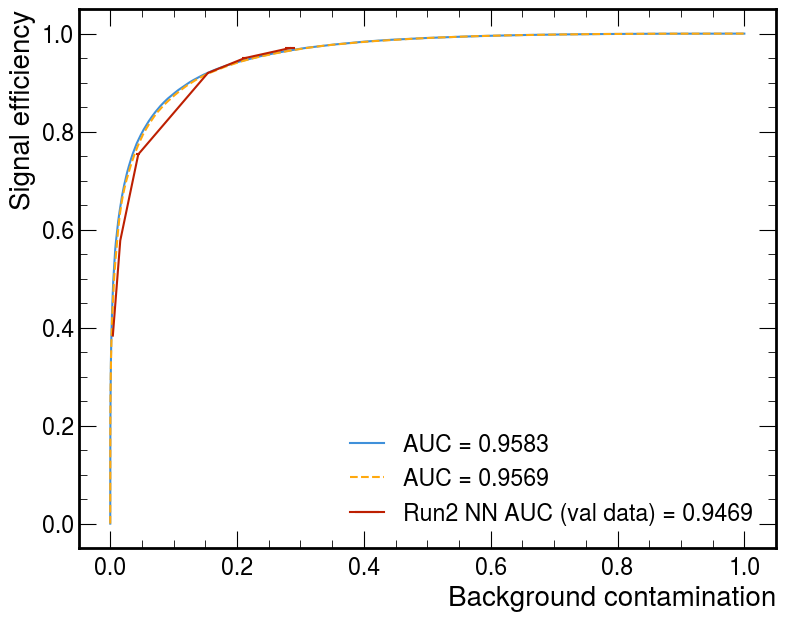

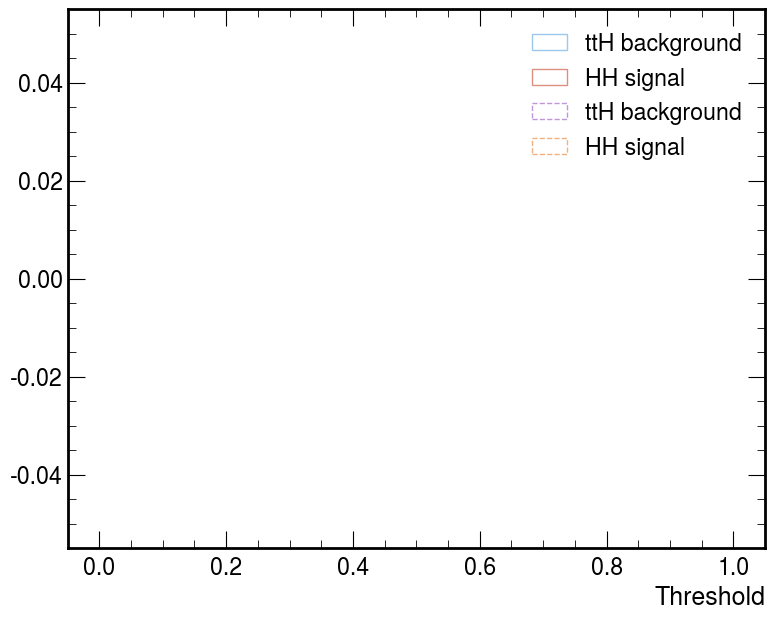

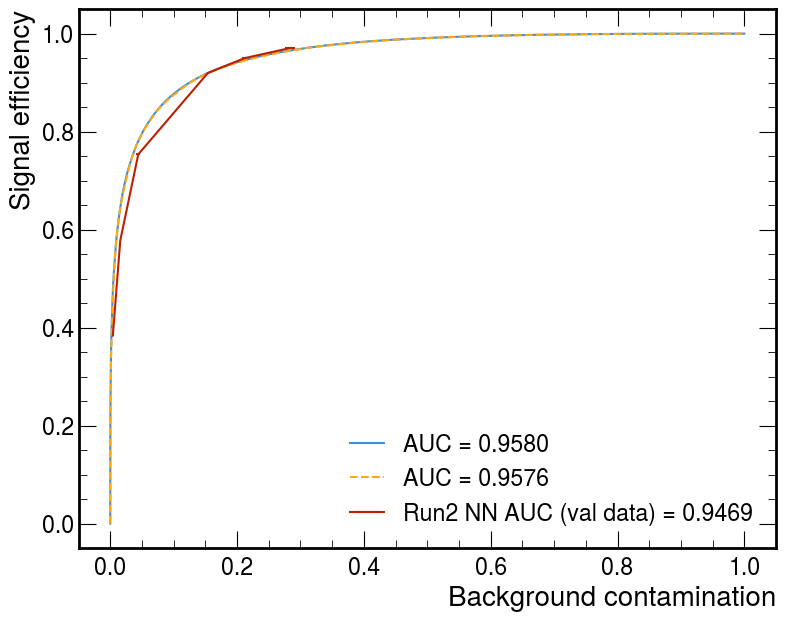

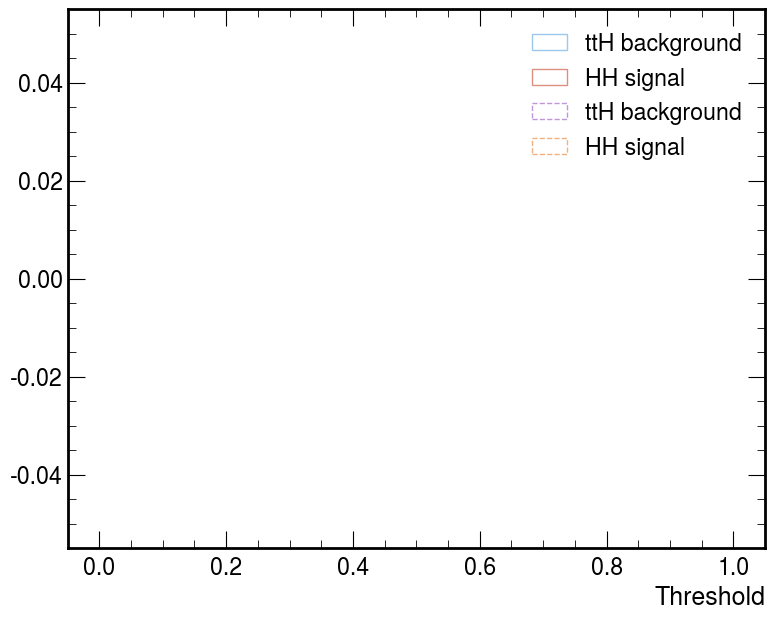

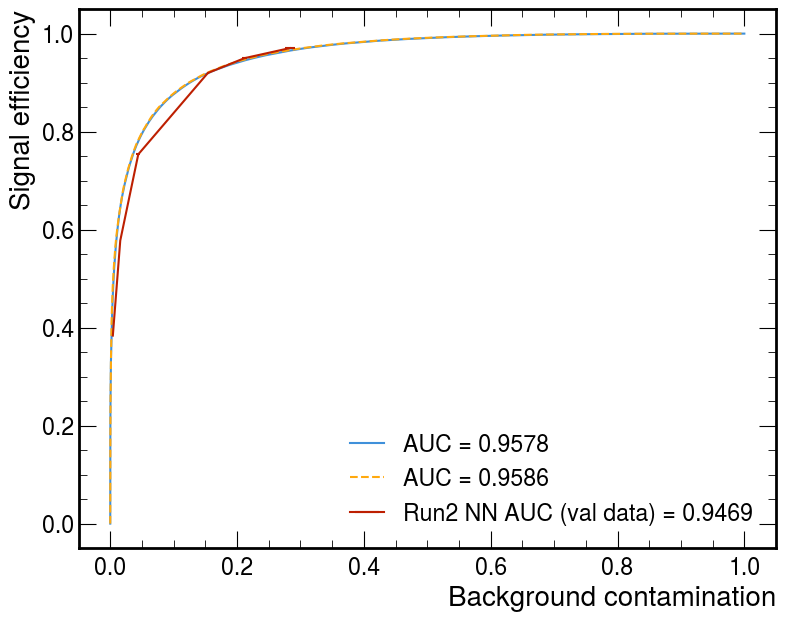

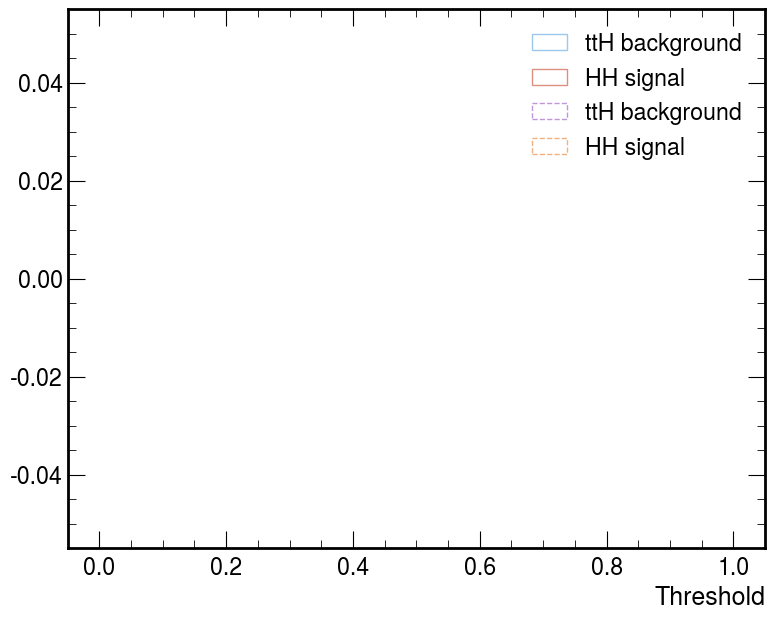

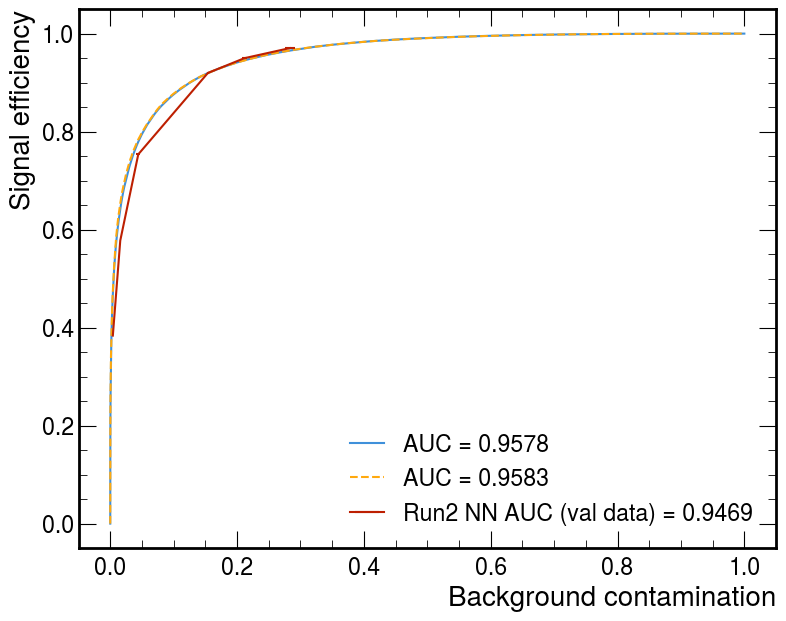

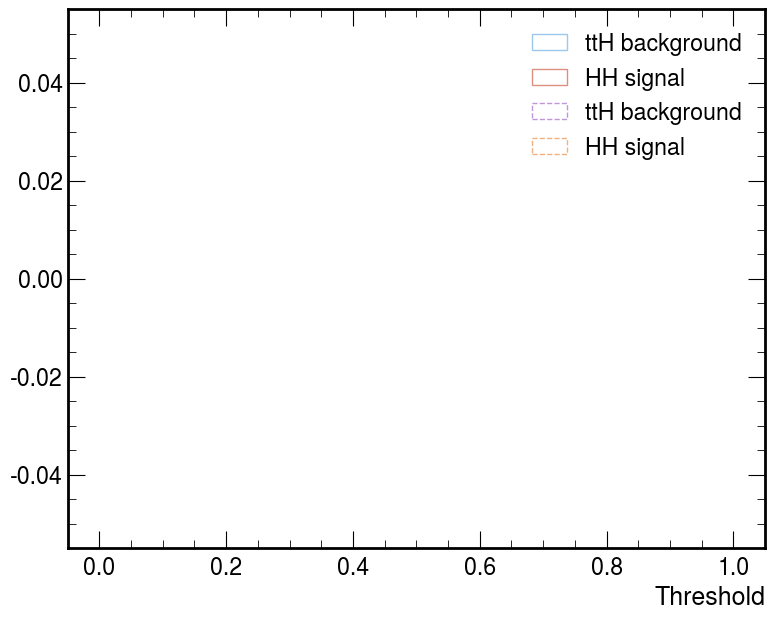

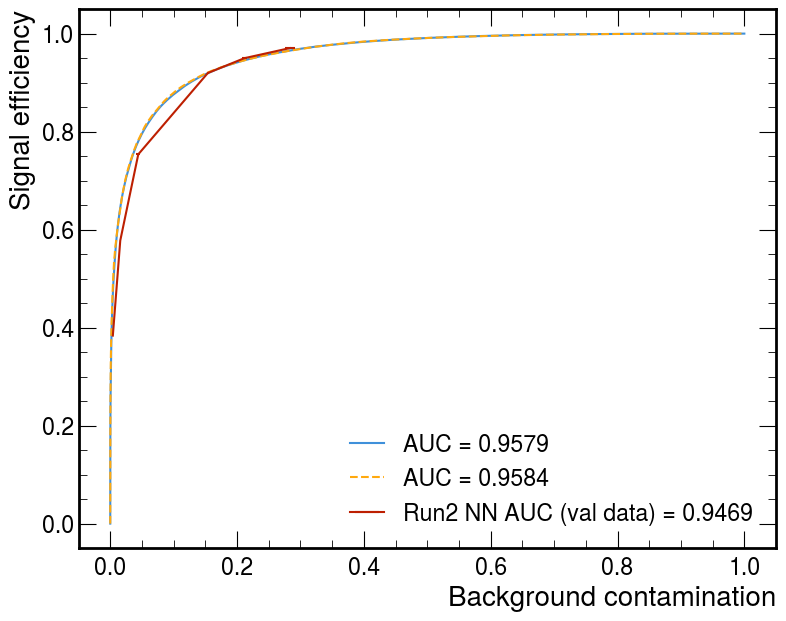

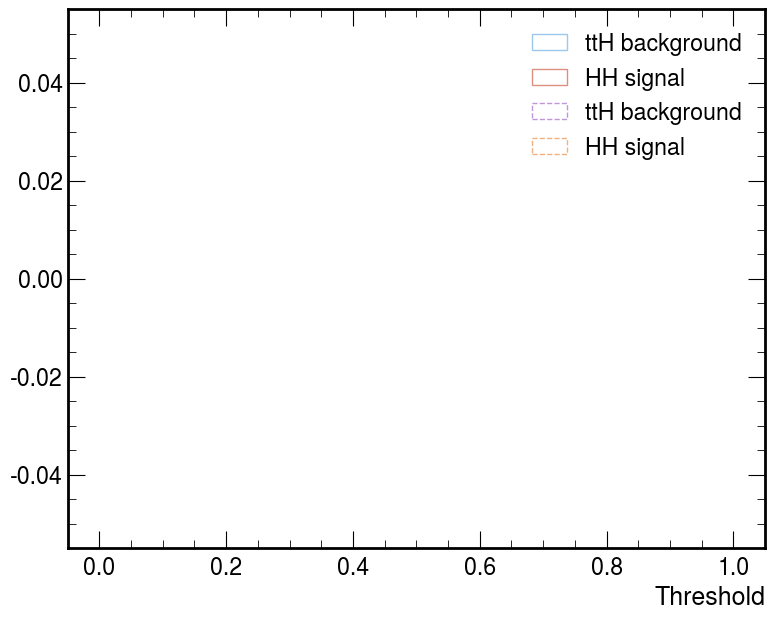

In [10]:
# CURRENT_TIME = '2024-08-10_13-16-12'  # extra_vars
CURRENT_TIME = '2024-08-10_10-29-50'  # base_vars
plot_destdir = OUTPUT_DIRPATH + 'plots'
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)

for fold_idx, (train_IN_dict, val_IN_dict) in enumerate(zip(IN_perf_dict['train'], IN_perf_dict['val'])):
    plot_roc([train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, '_train_val_comparison', method='IN_arr')
    plot_output_score([train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, '_train_val_comparison', method='IN_arr')

##### Mass sculpting